In [23]:
# Modelo Predictivo – Diabetes Dataset

# Este notebook demuestra paso a paso la creación de un modelo predictivo
# utilizando datos sintéticos basados en el dataset original de condiciones médicas.

# Objetivos:
# - Generar datos de entrenamiento realistas
# - Entrenar un modelo de clasificación
# - Visualizar resultados
# - Preparar datos para persistencia en PostgreSQL



In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix




In [ ]:
df = pd.read_csv("../data/cleaned/diabetes_cleaned.csv")

df.head()


,id,full_name,age,gender,smoking_status,bmi,blood_pressure,glucose_levels,condition
0,1,User0001,53,male,non-smoker,27.340637,134.832624,135.082933,Pneumonia
1,2,User0002,30,male,non-smoker,27.340637,105.315064,135.082933,Diabetic
2,3,User0003,18,male,non-smoker,35.612486,134.832624,135.082933,Pneumonia
3,4,User0004,53,male,non-smoker,27.340637,99.119829,135.082933,Pneumonia
4,5,User0005,76,male,non-smoker,27.340637,134.832624,135.082933,Diabetic


In [34]:
df.describe()
df["condition"].value_counts()




condition
Diabetic     6013
Pneumonia    2527
Cancer       1460
Name: count, dtype: int64

In [35]:
n_samples = 2000

synthetic_data = pd.DataFrame({
    "age": np.random.normal(df.age.mean(), df.age.std(), n_samples).astype(int),
    "bmi": np.random.normal(df.bmi.mean(), df.bmi.std(), n_samples),
    "blood_pressure": np.random.normal(df.blood_pressure.mean(), df.blood_pressure.std(), n_samples),
    "glucose_levels": np.random.normal(df.glucose_levels.mean(), df.glucose_levels.std(), n_samples),
    "gender": np.random.choice(df.gender.unique(), n_samples),
    "smoking_status": np.random.choice(df.smoking_status.unique(), n_samples),
    "condition": np.random.choice(df.condition.unique(), n_samples)
})


In [36]:
encoder = LabelEncoder()

for col in ["gender", "smoking_status", "condition"]:
    synthetic_data[col] = encoder.fit_transform(synthetic_data[col])


In [40]:
X = synthetic_data.drop("condition", axis=1)
y = synthetic_data["condition"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [31]:
X = df.drop("condition", axis=1)
y = df["condition"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [41]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)





,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [42]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.14      0.19       178
           1       0.36      0.36      0.36       230
           2       0.29      0.44      0.35       192

    accuracy                           0.32       600
   macro avg       0.32      0.31      0.30       600
weighted avg       0.32      0.32      0.31       600



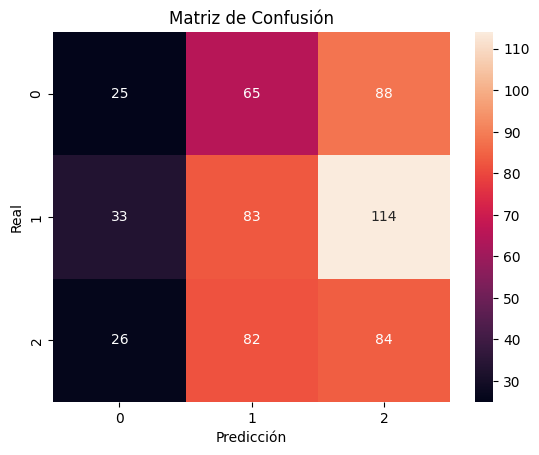

In [43]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()



In [44]:
results = X_test.copy()
results["real_condition"] = y_test.values
results["predicted_condition"] = y_pred

results.head(10)



,age,bmi,blood_pressure,glucose_levels,gender,smoking_status,real_condition,predicted_condition
1860,59,36.956432,142.943238,162.855787,1,1,1,2
353,57,20.396713,130.517917,96.425839,0,0,2,2
1333,52,33.033788,142.892169,139.279123,1,1,1,2
905,47,32.007707,126.087290,126.421404,0,1,2,2
1289,46,26.249446,129.924101,132.370555,1,0,0,1
1273,31,24.685041,126.292338,165.124378,1,1,2,1
938,50,28.058139,146.844307,153.756874,0,1,1,2
1731,44,24.772175,107.740464,175.565910,0,0,1,0
65,44,31.925055,123.219675,146.286983,1,0,1,1
1323,22,33.708671,144.571585,150.323626,1,1,0,1


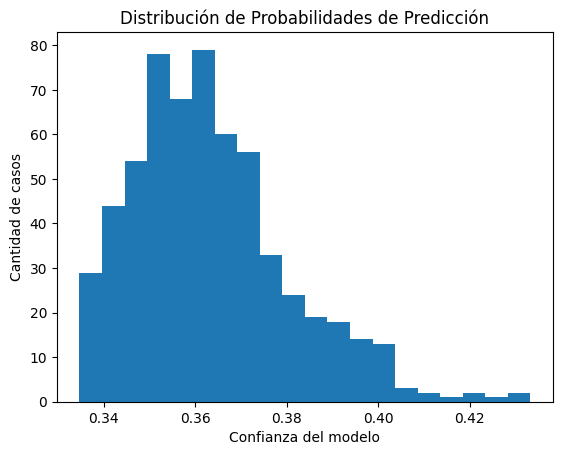

In [45]:
proba = model.predict_proba(X_test)

plt.hist(proba.max(axis=1), bins=20)
plt.title("Distribución de Probabilidades de Predicción")
plt.xlabel("Confianza del modelo")
plt.ylabel("Cantidad de casos")
plt.show()
